##Saliency
Like class activation maps, saliency maps also tells us what parts of the image the model is focusing on when making its predictions.

* The main difference is in saliency maps, we are just shown the relevant pixels instead of the learned features.
* We can generate saliency maps by getting the gradient of the loss with respect to the image pixels.
* This means that changes in certain pixels that strongly affect the loss will be shown brightly in your saliency map.


###Imports


In [37]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Build the model

For the classifier, we will use the Inception V3 model available in Tensorflow Hub. This has pre-trained weights that is able to detect 1001 classes.



In [38]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"),
  tf.keras.layers.Activation("softmax")
])

# build the model base on a specified batch input shape
model.build([None, 300, 300, 3])

### Get a sample image
We will download a photo of a Siberian Husky that our model will classify. 


In [39]:
# If we want to try the dog, uncomment this line
# !wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# If we want to try the cat, uncomment this line
!wget -O image.jpg https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492__340.jpg

--2023-02-23 13:42:03--  https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.15.16, 104.18.14.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.15.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39908 (39K) [binary/octet-stream]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  38.97K  --.-KB/s    in 0.001s  

2023-02-23 13:42:03 (55.9 MB/s) - ‘image.jpg’ saved [39908/39908]



### Preprocess the image
The image needs to be preprocessed before being fed to the model. This is done in the following steps:



In [40]:
# read the image
img = cv2.imread("image.jpg")

# format it to be the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)


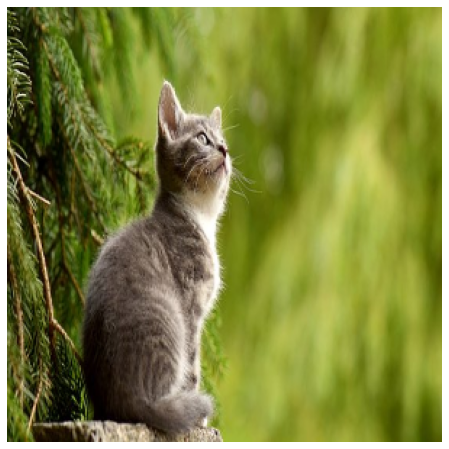

In [41]:
#We can now preview our input image.

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

### Compute Gradients

We will now get the gradients of the loss with respect to the input image pixels. 

In [42]:
#If we downloaded the cat, use this line instead
#class_index = 251 # Siberian Husky's in ImageNet

# If you downloaded the cat, use this line instead
class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
  # cast image to float
  inputs = tf.cast(image, tf.float32)

  # watch the input pixels
  tape.watch(inputs)

  # generate the predictions
  predictions = model(inputs)

  # get the loss
  loss = tf.keras.losses.categorical_crossentropy(
      expected_output, predictions
  )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

### Visualize the results
Now that we have the gradients, we will do some postprocessing to generate the saliency maps and overlay it on the image.



In [43]:
gradients.shape
gradients

<tf.Tensor: shape=(1, 300, 300, 3), dtype=float32, numpy=
array([[[[ 1.8510054e-04, -3.9206134e-04, -5.8269634e-05],
         [ 4.0093085e-04, -4.6071611e-04, -8.5686639e-05],
         [ 7.6308631e-04, -5.9368182e-04, -7.8491466e-05],
         ...,
         [ 4.8207107e-04,  6.2234153e-04, -7.8620511e-04],
         [ 1.1304066e-04,  5.0127594e-04, -3.3911772e-04],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 3.4927810e-04, -4.0650059e-04, -2.8309716e-05],
         [ 9.4966503e-04, -3.8589147e-04, -9.2898779e-05],
         [ 1.0973142e-03, -9.4647211e-04, -3.2462095e-04],
         ...,
         [ 3.5585818e-04,  2.9943900e-03, -3.4206791e-05],
         [-4.8016684e-04,  1.2697575e-03, -6.4932836e-05],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 2.4403507e-04, -4.4163939e-04,  2.4293050e-04],
         [ 8.1263104e-04, -8.6410053e-04,  1.0030650e-04],
         [ 6.2206900e-04, -2.3705899e-03, -1.2664066e-04],
         ...,
         [-

In [44]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be push to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8
)

# remove the channel dimension to make the tensor a 2D tensor
normalized_tensor = tf.squeeze(normalized_tensor)

In [45]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

0.74117786
0.0

(139, 104)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


Now let's see what this looks like when plotted. The white pixels show the parts the model focused on when classifying the image.


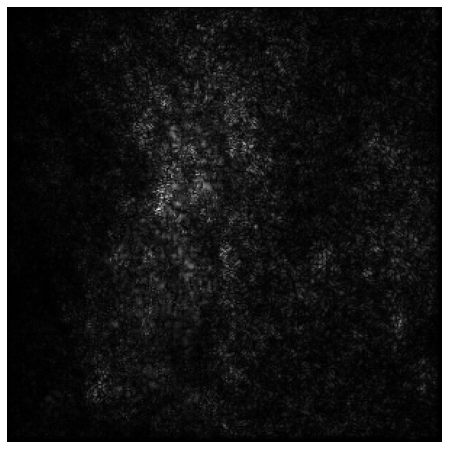

In [46]:

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the husky and that is a good indication that the model is looking at the correct part of the image.


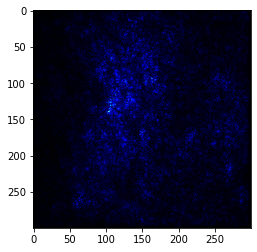

In [47]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
plt.imshow(gradient_color)

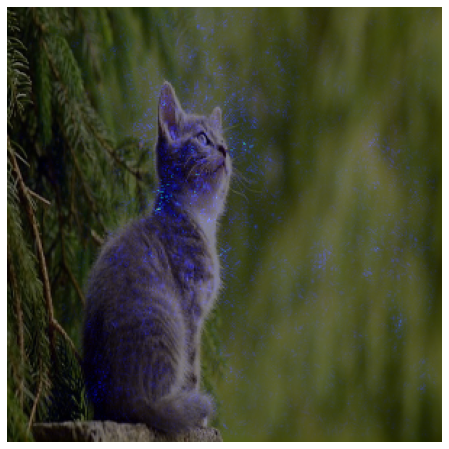

In [48]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis("off")
plt.show()